In [240]:
import pandas as pd
from dateparser.search import search_dates
import seaborn as sns
import glob
from tabula import read_pdf
import numpy as np

dataf = 'SDcountySituation-{}.csv'
locf = 'SDcountyLocations-{}.csv'
tab_hist = {}

In [58]:
# Don't run this anymore!! We only needed it once.
# I used wayback machine to collect the county data for the dates before I began this project, starting with first day over 100 cases
# for some reason the wayaback and the current web scrape produce different numbers of tables
'''get_historical_data = [
    'https://web.archive.org/web/20200320184055/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200321141257/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200322080211/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200323094801/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200324003021/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
]

for link in get_historical_data:
    tab = pd.read_html(link)
    #comes down as a list of each column seperately, with the header the same in each column-table
    table = tab[2].drop(0)
    # setup header and index
    cs =  table.iloc[0,:].to_list()
    cs[0] = 'index'
    table.columns = cs
    table = table.drop(1).set_index('index')
    # get todays date from that header we threw away on each column
    dt = search_dates(tab[2].iloc[0,0])[-1][1]
    today = dt.strftime('%Y-%m-%d')
    # theres some variability in nomenclature to deal with from day to day
    idx = table.index.to_series()
    idx[ 'Hospitalized' == idx ] = 'Hospitalizations'
    table.index = idx
    if not 'Intensive Care' in idx:
        table.loc['Intensive Care',:] = 0
        
    print(today)
    # record todays data for posterity
    table.to_csv(dataf.format(today))
    tab_hist[today] = table
    '''

2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23


In [241]:
# From now on we can just load the data that's already in the repo
files = glob.glob('*.csv') # gets all .csv filenames in directory
for afile in files:
    dt = afile[18:28]
    print(dt)
    tab_hist[dt] = pd.read_csv(afile,index_col=0,header=0)

2020-03-22
2020-03-23
2020-03-21
2020-03-20
2020-03-24
2020-03-25
2020-03-19


In [382]:
# Run me every day! Website updates once a day at around 4pm
tab = pd.read_html('https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html')
#comes down as a list of each column seperately, with the header the same in each column-table
tabs = [ x.drop(0) for x in tab]
table = pd.concat(tabs)
# setup header and index
cs =  table.iloc[0,:].to_list()
cs[0] = 'index'
table.columns = cs
table = table.drop(1).set_index('index')
# get todays date from that header we threw away on each column
dt = search_dates(tab[0][0][0])[-1][1]
today = dt.strftime('%Y-%m-%d')

# OK, this is weird, starting 26 March the Total and non-county residents columns disappeared
# and everythign is under San Diego County Residents, even though I believe that is actuall the Total column
table.columns=['Total']

# record todays data for posterity
table.to_csv(dataf.format(today))
tab_hist[today] = table
print(today)
table

2020-03-26


,Total
index,
Total Positives,341
Age Groups,NaN
0-9 years,3
10-19 years,3
20-29 years,66
30-39 years,89
40-49 years,61
50-59 years,53
60-69 years,26


In [383]:
cases = pd.Series({key:int(value.loc['Total Positives','Total']) for key,value in tab_hist.items()}).sort_index()
hospitalizations = pd.Series({key:int(value.loc['Hospitalizations','Total']) for key,value in tab_hist.items()}).sort_index()
icu = pd.Series({key:int(value.loc['Intensive Care','Total']) for key,value in tab_hist.items()}).sort_index()
deaths = pd.Series({key:int(value.loc['Deaths','Total']) for key,value in tab_hist.items()}).sort_index()
totals = pd.DataFrame( {'Confirmed cases':cases, 'Hospitalizations':hospitalizations, 'ICU patients':icu, 'Deaths':deaths})

In [384]:
sns.set_style('darkgrid')
colors = sns.color_palette()
import matplotlib.pyplot as plt

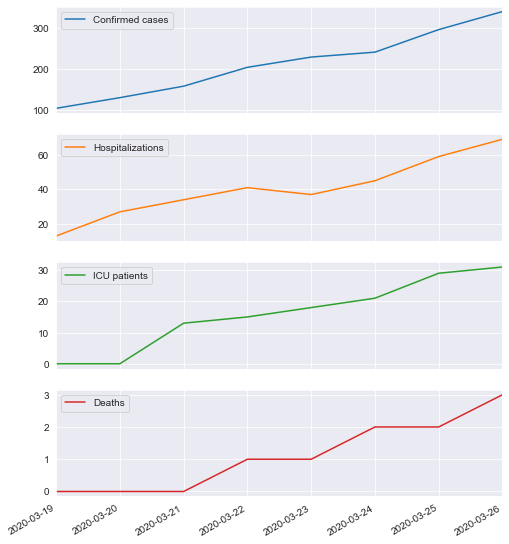

In [385]:
totals.plot(subplots=True,sharex=True,figsize=(8,10));

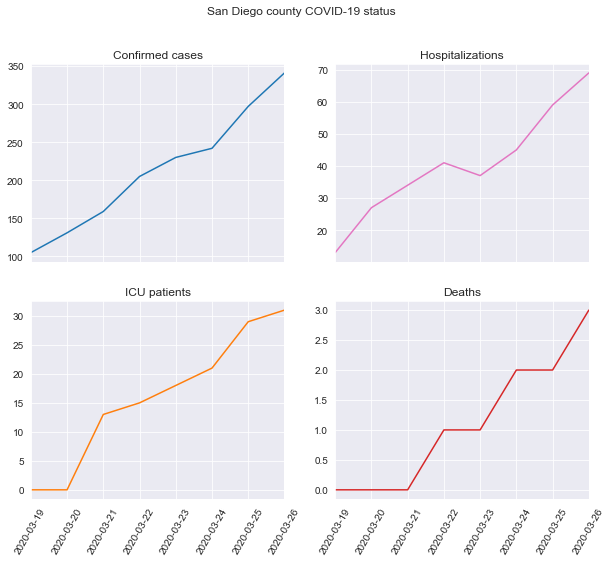

In [386]:
fig, ( (ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,8))
# I really hope I never have to add the argument logy=True to the plots
cases.plot(title='Confirmed cases', color=colors[0], ax=ax1); 
hospitalizations.plot(title='Hospitalizations', color=colors[6], ax=ax2);
icu.plot(title='ICU patients', color=colors[1], ax=ax3);
deaths.plot(title='Deaths', color=colors[3], ax=ax4);
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.suptitle('San Diego county COVID-19 status');

In [387]:
from scipy.optimize import curve_fit

def exfunc(x, a, b):
    return a * np.exp(b * x) 
    
def estimate_doubling_time(data):
    pest, pcov = curve_fit(exfunc, range(len(data)), data)
    doubling_time = np.log(2)/pest[1]
    ci95 = 1.96 * np.sqrt(pcov[1][1])
    
    return(doubling_time, ci95, pest, pcov)

def days_to_value(pest, y):
    '''
    pest = [a, b]
    y = a * exp( b * x )
    ln(y) - ln(a) = b * x
    x = ( ln(y) - ln(a) ) / b
    '''
    return (np.log(y) - np.log(pest[0]))/pest[1]



In [388]:
doubling_time, ci95, case_p_est, case_p_cov  = estimate_doubling_time(cases)
print('Estimating doubling time on confirmed cases data from 2020-03-19 to {}'.format(today))
print('Max likelihood estimate: {:4.3f} days'.format(doubling_time))
print('95% confidence interval: {:4.3f} - {:4.3f} days'.format(doubling_time-ci95, doubling_time+ci95))

Estimating doubling time on confirmed cases data from 2020-03-19 to 2020-03-26
Max likelihood estimate: 4.522 days
95% confidence interval: 4.504 - 4.541 days


In [389]:
doubling_time, ci95, hosp_p_est, hosp_p_cov = estimate_doubling_time(hospitalizations)
print('Estimating doubling time on hospitalizations data from 2020-03-19 to {}'.format(today))
print('Max likelihood estimate: {:4.3f} days'.format(doubling_time))
print('95% confidence interval: {:4.3f} - {:4.3f} days'.format(doubling_time-ci95, doubling_time+ci95))
print(hosp_p_est)

Estimating doubling time on hospitalizations data from 2020-03-19 to 2020-03-26
Max likelihood estimate: 4.058 days
95% confidence interval: 4.016 - 4.101 days
[20.7559645   0.17079952]


In [392]:
doubling_time, ci95, icu_p_est, icu_p_cov = estimate_doubling_time(icu['2020-03-21':])
print('Estimating doubling time on hospitalizations data from 2020-03-21 (first day ICU beds recorded) to {}'.format(today))
print('Max likelihood estimate: {:4.3f} days'.format(doubling_time))
print('95% confidence interval: {:4.3f} - {:4.3f} days'.format(doubling_time-ci95, doubling_time+ci95))

Estimating doubling time on hospitalizations data from 2020-03-21 (first day ICU beds recorded) to 2020-03-26
Max likelihood estimate: 3.739 days
95% confidence interval: 3.704 - 3.773 days


# The number of available hospital beds
"As of 2018, San Diego had 6,180 total hospital beds. Of those, about 68% were occupied at any given time. That leaves 1,950 beds, including 800 intensive care unit beds, available for new patients." - [https://www.kpbs.org/news/2020/mar/20/data-suggests-san-diego-hospitals-will-be-overfill/]

In [393]:
availbeds = 1950
availicu = 800

hospital_capacity = days_to_value(hosp_p_est,availbeds)
#print('{:4.2f} days until hospital capacity reached'.format(hospital_capacity))
print('Hospitals reach capacity on {}'.format(pd.Timestamp('2020-03-19') + pd.Timedelta('1 day')*hospital_capacity))

icu_capacity = days_to_value(icu_p_est,availicu)
#print('{:4.2f} days until ICU capacity reached'.format(icu_capacity))
print('ICUs reach capacity on {}'.format(pd.Timestamp('2020-03-21') + pd.Timedelta('1 day')*icu_capacity))



Hospitals reach capacity on 2020-04-14 14:19:38.844414724
ICUs reach capacity on 2020-04-12 08:33:44.205289965


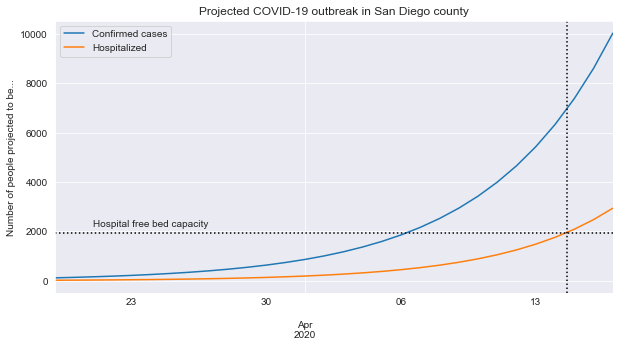

In [394]:
projcases = pd.DataFrame(exfunc(range(0,30),case_p_est[0],case_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=30)
                        ).astype(int)
projhosp = pd.DataFrame(exfunc(range(0,30),hosp_p_est[0],hosp_p_est[1]),
                        index=pd.date_range(start='2020-03-19',periods=30)
                        ).astype(int)
projicu = pd.DataFrame(exfunc(range(0,28),icu_p_est[0],icu_p_est[1]),
                        index=pd.date_range(start='2020-03-21',periods=28)
                        ).astype(int)

projcases.columns = ['Confirmed cases']
projhosp.columns = ['Hospitalized']
projicu.columns = ['in ICU beds']

projected = pd.merge(projcases,projhosp,left_index=True,right_index=True,how='outer')
#projected = pd.merge(projected,projicu,left_index=True,right_index=True,how='outer')

fig, ax = plt.subplots(figsize=(10, 5))
projected.plot(title='Projected COVID-19 outbreak in San Diego county',ax=ax);
plt.ylabel('Number of people projected to be...');
plt.axhline(y=availbeds,linestyle=':',color='k');
plt.axvline(x=ax.get_xbound()[0] + hospital_capacity, linestyle=':', color='k');
ax.annotate('Hospital free bed capacity',
            xy=(ax.get_xbound()[0]+2, 2200), xycoords='data', fontsize=10);

# but all this might be moot...
because I ran this by two people who actually know stuff, unlike me.

My summary: Hospitals could be stressed and not dealing well with the infected as soon as they have a couple of patients.  They will then adjust and just make-do as best they can, shutting down services, moving resources from here to there as much as they can.  These decisions will be made differently by each hospital so there's really no way to predict hospital capacity.

To read the actual exchange, see below

--Jason



Gerald Pao, an MD/PhD who's worked in virology for a long time... 

>Although this is a reasonable estimate at face value it does not take into account how a hospital works
You cannot have the highly contagious population in the same space as the rest of the patients who are there for other reasons.
So you need to ask how many barrier nursing negative pressure beds does the hospital have?
The answer is for any normal hospital the number of beds is between 5-10
I have asked my friends in CA  from the Bay area, LA and SD and no one has given me a number higher than 10
This means people will have to designate hospital wings to this task and somehow separate things. 
In places in Spain and Italy they sometimes designated particular hospitals for this task or had the ER designated for it and rearranged it.
In other ones they had particular floors closed off etc.
so the real capacity will depend on what the hospital administrators decide to do and will be made in uneven and unpredictable ways as there is no single set of rules on how to manage this.
Therefore the pressure on hospitals and when you will be out of capacity will be difficult to estimate. We do not have a national healthcare system as you know so it’s gonna be a a free for all.
>
>Gerald Pao 
>
>The Salk Institute for Biological Studies


Joel Wertheim, a bioinformatician who specializes in the evolution and epidemiology of HIV...  

>Hi Jason,
>
>Interesting  stuff.
>
>Another point to consider in the general design is the time-lag between all of these states. Most people are not admitted to the hospital for quite some time after infection. If they proceed to the ICU and/or death, that also can take weeks after initial infection/diagnosis. I’m not sure of the proportion of cases in San Diego diagnosed after admittance to the hospital, as opposed to be people who aren't (yet) sick enough to be hospitalized. 
>
>Also, at UC San Diego, negative pressure rooms were originally used for COVID patients (back when we were treating the first patients brought back from China). Now, they are just being used for procedures that would result in high likelihood of spread (i.e., intubation). So the number of beds can change with the severity of the epidemic (as Gerald also mentioned).
>
>Cheers,
>
>Joel  
>
>University of California San Diego


In [410]:
# these column locations are hand tuned 
locations = read_pdf('https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/COVID-19%20Daily%20Update_City%20of%20Residence.pdf', options="--columns 250.0,375.0", guess=False)

In [412]:
# because I'm not parsing the date out of the pdf, you should manually make sure this has been updated too before scraping!
# 3/25 version
'''locations = locations.set_index('County of San Diego')
locations = locations['San Diego County':'OVERALL TOTAL'].dropna()
locations.columns = locations.loc['San Diego County',:]
locations = locations.drop('San Diego County')
locations.to_csv(locf.format(today))
print(today)
locations'''
None;

In [413]:
# because I'm not parsing the date out of the pdf, you should manually make sure this has been updated too before scraping!
# 3/26 version
locations = locations.set_index('County of San Diego')
locations = locations['San Diego County':'Total San Diego County Residents'].dropna()
locations.columns = locations.loc['San Diego County',:]
locations = locations.drop('San Diego County')
locations.to_csv(locf.format(today))
print(today)
locations

2020-03-26


San Diego County,Count,Percentage** of Overall Total
County of San Diego,,
Incorporated City,313,91.8%
Carlsbad,15,4.4%
Chula Vista,17,5.0%
Del Mar,5,1.5%
El Cajon,19,5.6%
Encinitas,12,3.5%
Escondido,7,2.1%
La Mesa,1,0.3%
Lemon Grove,1,0.3%
